In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import pandas as pd
import seaborn as sns
import pickle

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim

import time
from tqdm.notebook import tqdm

In [ ]:
with open('/content/drive/MyDrive/data/pic.bin', 'rb') as p:
    data = pickle.load(p)

train = data[0]
test = data[1]

train_set = train[0]
train_eval = train[1]

test_set = test[0]
test_eval = test[1]

In [ ]:
len(test_eval[1])

81

In [ ]:
def real_to_binary(real_data):
    binary_data = []
    for index in range(len(real_data)):
        eval_norm_num = []
        for ind in range(len(real_data[index])):
            bin_data = 0

            if real_data[index][ind] > 0:
                bin_data = 1
            else:
                bin_data = 0
            
            eval_norm_num .append(bin_data)

        binary_data.append(eval_norm_num)
    return binary_data

In [ ]:
eval_norm = real_to_binary(train_eval)
eval_norm_test = real_to_binary(test_eval)
eval_zero = np.array([0] * len(test_eval[1]))

In [ ]:
comp_data = []
for data_num in range(len(train_set)):
    comp_data.append(np.r_[train_set[data_num], eval_norm[data_num]])

In [ ]:
comp_data_test = []
for data_num in range(len(test_set)):
    comp_data_test.append(np.r_[test_set[data_num], eval_norm_test[data_num]])

In [ ]:
comp_data_unk = []
for data_num in range(len(test_set)):
    comp_data_unk.append(np.r_[test_set[data_num], eval_zero])

In [ ]:
# 使用するDeviceの指定
# GPUが使用できる方はGPU, 使用できない方はCPUを使用するように設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Tensorに変換
x_train = torch.Tensor(comp_data)
y_train = torch.Tensor(train_eval)
x_test = torch.Tensor(comp_data_unk)
y_test = torch.Tensor(test_eval)
# データセッを作成
ds_train = TensorDataset(x_train, y_train)
ds_test = TensorDataset(x_test, y_test)
# DataLoaderを作成
loader_train = DataLoader(ds_train, batch_size=1, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=1, shuffle=True)

In [ ]:
class RBM(nn.Module):
    """RBM with PyTorch
    Attributes:
        b : 可視ユニットのバイアス項
        c : 隠れユニットのバイアス項
        w : 重みパラメータ
        n_vis : 可視ユニットの数 
        n_hid : 隠れユニットの数
        epoch : エポック数
        learning_rate : 学習率
        batch_size : ミニバッチサイズ
        initial_std : 初期状態の分散
        seed : 乱数のシード
        device : デバイスを指定
    """
    def __init__(self, n_vis=107, n_hid=32, k=20, epoch=10, learning_rate=0.1, 
                 batch_size=4, initial_std=0.01, seed=0, device='cpu'):
        super(RBM, self).__init__()
        self.n_hid = n_hid
        self.n_vis = n_vis
        self.device = device
        self.b = torch.zeros(1, n_vis,  device=device) ##torch.zeros : 0の要素で埋まる行列
        self.c = torch.zeros(1, n_hid,  device=device)
        self.w = torch.empty((n_hid, n_vis), device=device).normal_(mean=0, std=initial_std)   ##torch.empty.normal_() 平均 0 , 初期状態の分散 の値が入った行列
        self.k = k
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def visible_to_hidden(self, v):
        """
        可視ユニットから隠れユニットをサンプル
        """
        p = torch.sigmoid(F.linear(v, self.w, self.c)) ## torch.shigmaid :input の要素のシグモイドを持つ新しいテンソルを返す
        return p.bernoulli()

    def hidden_to_visible(self, h):
        """
        隠れユニットから可視ユニットをサンプル
        """
        p = torch.sigmoid(F.linear(h, self.w.t(), self.b))
        return p.bernoulli()
    
    def com_hiddens(self, v):
        """
        P(h=1|v)を計算
        """
        return torch.sigmoid(F.linear(v, self.w, self.c))

    def sample_v(self, v, gib_num=1):
        """
        データをサンプリング
        """
        v = v.view(-1, self.n_vis)
        v = v.to(self.device)
        h = self.visible_to_hidden(v)
        for _ in range(gib_num):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v, v_gibb

    def sample_ph(self, v):
        """
        phをサンプリング
        """
        v = v.view(-1, self.n_vis)  ## .view() : １つ目の引数に-1を入れることで、２つ目の引数で指定した値にサイズ数を自動的に調整
        v = v.to(self.device)
        ph = torch.sigmoid(F.linear(v, self.w, self.c)) 
        h = ph.bernoulli()
        # Gibbs Sampling 1 ~ k
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            ph_gibb =  torch.sigmoid(F.linear(v_gibb, self.w, self.c))
            h = ph_gibb.bernoulli()
        return ph, ph_gibb

    def free_energy(self, v):
        """
        自由エネルギーを計算
        """
        v_term = torch.matmul(v, self.b.t())  ## torch.matmul : テンソルの積
        w_x_h = torch.matmul(v, self.w.t()) + self.c
        h_term = torch.sum(F.softplus(w_x_h), dim=1)  ## torch.sum : テンソルの全要素の和
        return -h_term - v_term

    def loss(self, v):
        """
        疑似対数尤度を計算
        """
        flip = torch.randint(0, v.size()[1], (1,)) # flip = 0~v.size()[1]
        v_fliped = v.clone()  ## .clone() : listの複製
        v_fliped[:, flip] = 1 - v_fliped[:, flip] # if v[i,j] = 0 -> 1 else if 1 -> 0
        free_energy = self.free_energy(v)
        free_energy_fliped = self.free_energy(v_fliped)
        return  v.size()[1]*F.softplus(free_energy_fliped - free_energy)

    def batch_fit(self, v_pos):
        """
        ミニバッチあたりの学習更新
        """
        # positive part
        ph_pos = self.com_hiddens(v_pos)
        # negative part
        v_neg = self.hidden_to_visible(self.h_samples) 
        ph_neg = self.com_hiddens(v_neg)

        lr = (self.learning_rate) / v_pos.size()[0]
        # Update W
        update = torch.matmul(ph_pos.t(), v_pos) - torch.matmul(ph_neg.t(), v_neg)
        self.w += lr * update
        self.b += lr * torch.sum(v_pos - v_neg, dim=0)
        self.c += lr * torch.sum(ph_pos - ph_neg, dim=0)
        # PCDのために隠れユニットの値を保持
        self.h_samples = ph_neg


    def fit(self, train_loader, train_tensor):
        '''
        学習を実行
        '''
        self.losses = []
        self.errors = []
        # initialization of hidden units
        self.h_samples = torch.zeros(self.batch_size, self.n_hid, device=device)
        for epoch in range(self.epoch):
            running_loss = 0.0
            error_values = []
            start = time.time()
            for data, _ in train_loader:
                data = data.view(-1, self.n_vis)
                data = data.to(self.device)
                self.batch_fit(data)
            # 擬似対数尤度を計算
            for data, _ in train_loader:
                data = data.view(-1, self.n_vis)
                data = data.to(self.device)
                v, v_gibb = self.sample_v(data)
                error_value = torch.sum(torch.abs(v - v_gibb))
                error_values.append(error_value.detach().cpu().numpy())
                running_loss += self.loss(data).mean().item()/data.size()[1]
            error = np.mean(error_values)
            self.errors.append(error)
            self.losses.append(running_loss)
            end = time.time()
            print(f'Epoch {epoch+1} pseudo-likelihood = {running_loss:.3f}, {end-start:.2f}s, error-value = {error:.2f}')

    def train(self, test_data):
        '''
        sample_test_data
        '''
        self.v_sample = []
        for td in test_data:
            label = td
            v, v_gibb = model.sample_v(label, gib_num=100)
            v = v.detach().cpu().numpy()
            v_gibb = v_gibb.detach().cpu().numpy()
            self.v_sample.append(v_gibb)

In [ ]:
# RBMインスタンスの作成
model = RBM(initial_std=0.01, learning_rate=0.0005, epoch=15000, batch_size=1, device=device)
# 学習の実行
losses = model.fit(loader_train, x_train)


ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 10001 pseudo-likelihood = 14791.848, 1.03s, error-value = 2.42
Epoch 10002 pseudo-likelihood = 15021.618, 1.04s, error-value = 2.37
Epoch 10003 pseudo-likelihood = 14420.004, 1.03s, error-value = 2.36
Epoch 10004 pseudo-likelihood = 13973.014, 1.04s, error-value = 2.33
Epoch 10005 pseudo-likelihood = 14027.858, 1.02s, error-value = 2.44
Epoch 10006 pseudo-likelihood = 14544.699, 1.02s, error-value = 2.50
Epoch 10007 pseudo-likelihood = 14294.559, 1.01s, error-value = 2.58
Epoch 10008 pseudo-likelihood = 14734.941, 1.06s, error-value = 2.54
Epoch 10009 pseudo-likelihood = 14886.409, 1.01s, error-value = 2.65
Epoch 10010 pseudo-likelihood = 14751.594, 1.02s, error-value = 2.69
Epoch 10011 pseudo-likelihood = 14434.139, 1.02s, error-value = 2.53
Epoch 10012 pseudo-likelihood = 14671.183, 1.01s, error-value = 2.54
Epoch 10013 pseudo-likelihood = 14366.145, 1.03s, error-value = 2.50
Epoch 10014 pseudo-likelihood = 14826.746, 1.02s, error-value = 2.50
Ep

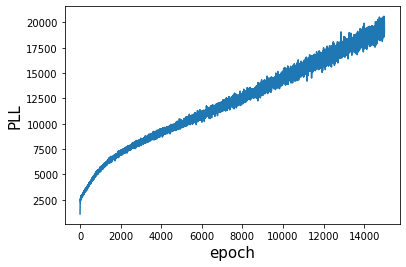

In [ ]:
epoch_num = torch.arange(1, model.epoch+1)
losses = torch.Tensor(model.losses)
fig, ax = plt.subplots()
ax.plot(epoch_num, losses)
ax.set_xlabel('epoch')
ax.set_ylabel('PLL')
ax.set_xlabel('epoch', fontsize=15)
ax.set_ylabel('PLL', fontsize=15)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=10)

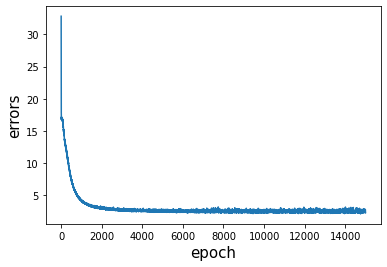

In [ ]:
epoch_num = torch.arange(1, model.epoch+1)
errors = torch.Tensor(model.errors)
fig, ax = plt.subplots()
ax.plot(epoch_num, errors)
ax.set_xlabel('epoch')
ax.set_ylabel('errors')
ax.set_xlabel('epoch', fontsize=15)
ax.set_ylabel('errors', fontsize=15)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=10)

In [ ]:
## save model

model_path = '/content/drive/MyDrive/Colab Notebooks/RBMForBinData/rbm_apply.pt'
torch.save(model, model_path)

In [ ]:
train_data = np.array(comp_data)
test_data = x_test
model.train(test_data)
v_sample = model.v_sample
collect_data = np.array(comp_data_test)

In [ ]:
## 一致率の定義

def match_rate(call_list, start_num, end_num):
    for share_idx in range(len(collect_data)):
        diff = np.abs(v_sample[share_idx][0][start_num:end_num] - collect_data[share_idx][start_num:end_num])
        diff_sum = np.sum(diff)

        ## 一致の判定
        if diff_sum == 0:
            call_list.append(share_idx)

    match_rate = round(len(call_list)/len(collect_data), 3)
    return match_rate

In [ ]:
## 完全一致率
per_match_list = []
per_match_rate = match_rate(per_match_list, 0, 107)
print('per_match_rate = ', per_match_rate)

## トップスラベルの一致率
label_match_list = []
label_match_rate = match_rate(label_match_list, 0, 26)
print('label_match_rate = ', label_match_rate)

## トップスの種類の一致率
tops_match_list = []
tops_match_rate = match_rate(tops_match_list, 0, 6)
print('tops_match_rate = ', tops_match_rate)

## 色相環の一致率
circle_match_list = []
circle_match_rate = match_rate(circle_match_list, 6, 18)
print('circle_match_rate = ', circle_match_rate)

## 色情報の2進数表記の一致率
clinf_match_list = []
clinf_match_rate = match_rate(clinf_match_list, 18, 26)
print('clinf_match_rate = ', clinf_match_rate)

## 評価値の一致率
eval_match_list = []
eval_match_rate = match_rate(eval_match_list, 26, 107)
print('eval_match_rate = ', eval_match_rate)

per_match_rate =  0.0
label_match_rate =  0.0
tops_match_rate =  0.329
circle_match_rate =  0.329
clinf_match_rate =  0.005
eval_match_rate =  0.065


In [ ]:
## トップスの種類　色相環　両方一致
tc_match_list = []
tc_match_rate = match_rate(tc_match_list, 0, 18)
print('tc_match_rate = ', tc_match_rate)

tc_match_rate =  0.125


In [ ]:
## 両方一致時の評価値の一致
char_match_list = []

for tc_num in tc_match_list:
    for eval_num in eval_match_list:
        if tc_num == eval_num:
            char_match_list.append(tc_num)

char_match_rate = round(len(char_match_list)/len(test_data), 3)

print('char_match_rate = ', char_match_rate)

char_match_rate =  0.065


In [ ]:
## test_label が train_label　と一致
test_train_list = []
train_test_list = []
start_num, end_num = 0, 26
for test_idx in range(len(test_data)):
    for train_idx in range(len(train_data)):
        diff = np.abs(v_sample[test_idx][0][start_num:end_num] - train_data[train_idx][start_num:end_num])
        diff_sum = np.sum(diff)

        ## 一致の判定
        if diff_sum == 0:
            test_train_list.append(test_idx)
            train_test_list.append(train_idx)

test_train_rate = round(len(test_train_list)/len(test_data), 3)

## evalも一致
tteval_match_list = []
for ttnum in range(len(test_train_list)):
    diff = np.abs(v_sample[ttnum][0][26:107] - train_data[ttnum][26:107])
    diff_sum = np.sum(diff)

    if diff_sum == 0:
        tteval_match_list.append(ttnum)

tteval_match_rate = round(len(tteval_match_list)/len(test_train_list), 3)

print('tteval_match_rate', tteval_match_rate)

tteval_match_rate 0.0
